In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import pairwise_distances
import networkx as nx
import torch_geometric.utils as g_util
import os
from tqdm import tqdm
import openslide as osd

/home/stat-huamenglei/anaconda3/envs/TEA_graph_clone/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# sample_name
distance_thresh = 4.3
supernode_path = '/mnt/usb4/hml/TEA-graph-master/data/Graph_test_resize/TCGA/GC/superpatch/TCGA-3M-AB46_0.75.csv'
location = '/mnt/usb4/hml/TEA-graph-master/data/Graph_test_resize/TCGA/GC/original/TCGA-3M-AB46_node_location_list.csv'
pt = '/mnt/usb4/hml/TEA-graph-master/data/Graph_test_resize/TCGA/GC/superpatch/TCGA-3M-AB46_0.75_graph_torch.pt'

In [3]:
graph = torch.load(pt)
supernode = pd.read_csv(supernode_path)
location = pd.read_csv(location)
supernode_x = []
supernode_y = []
supernode_num = supernode['Unnamed: 0'].tolist()

supernode_x = location.loc[supernode_num]['X']
supernode_y = location.loc[supernode_num]['Y']

coordinate_df = pd.DataFrame({'X': supernode_x, 'Y': supernode_y})
coordinate_list = np.array(coordinate_df.values.tolist())
coordinate_matrix = pairwise_distances(coordinate_list, n_jobs=12)


adj_matrix = np.where(coordinate_matrix >= distance_thresh, 0, 1)
Edge_label = np.where(adj_matrix == 1)

Adj_from = np.unique(Edge_label[0], return_counts=True)
Adj_to = np.unique(Edge_label[1], return_counts=True)

# 单边的点
Adj_from_singleton = Adj_from[0][Adj_from[1] == 1]
Adj_to_singleton = Adj_to[0][Adj_to[1] == 1]

Adj_singleton = np.intersect1d(Adj_from_singleton, Adj_to_singleton)

coordinate_matrix_modify = coordinate_matrix

fromlist = Edge_label[0].tolist()
tolist = Edge_label[1].tolist()

edge_index = torch.tensor([fromlist, tolist], dtype=torch.long)
graph.edge_index = edge_index
connected_graph = g_util.to_networkx(graph, to_undirected=True)
connected_graph = [connected_graph.subgraph(item_graph).copy() for item_graph in
                    nx.connected_components(connected_graph) if len(item_graph) > 100]

In [27]:
mata_data

,WSIs,Gender,Age,ajcc_pathologic_t,ajcc_pathologic_n,ajcc_pathologic_m,ajcc_pathologic_stage,death_status,death_time,group
0,1400716,1,53,T2,N0,M0,ⅠB,0,1923,0
1,1400793,1,32,T2,N3a,M0,ⅢA,0,3157,1
2,1400865,1,46,T2,N0,M0,ⅠB,0,2534,0
3,1400894,1,49,T3,N0,M0,ⅡA,0,1832,0
4,1401025,0,57,T4b,N0,M0,ⅢA,0,2300,1
...,...,...,...,...,...,...,...,...,...,...
2331,1644991,1,54,T1a,N0,M0,ⅠA,0,2072,0
2332,1645083,1,51,T3,N2,M0,ⅢA,1,457,1
2333,1645084,0,63,T3,N0,M0,ⅡA,0,2071,0
2334,1645155,0,37,T3,N3b,M0,ⅢC,1,505,1


In [40]:
image_dir = '/mnt/usb3/1.WSI_数据/1.GC_2300/WSI数据'
mata_path = '/home/stat-huamenglei/TEA-graph-master/GC_2300_all.csv'
save_dir = '/mnt/usb/huamenglei/GC_2300/GC'

files = os.listdir(image_dir)
mata_data = pd.read_csv(mata_path)
csv_id = list(mata_data['WSIs'])
ids = []
for id in files:
    if id[:12] in csv_id:
        ids.append(id)
final_files = [os.path.join(image_dir, file) for file in files]
final_files.sort(key=lambda f: os.stat(f).st_size, reverse=False)


for image in tqdm(final_files):
    id = image.split('/')[-1][:-4]
    # if image.split('/')[-1][:-4] =='TCGA-CD-8525':
    #     ipdb.set_trace()
    path = os.path.join(save_dir,'superpatch',f'{id}_0.75_graph_torch.pt')
    supernode_path = f'/mnt/usb/huamenglei/GC_2300/GC/superpatch/{id}_0.75.csv'
    location_path = f'/mnt/usb/huamenglei/GC_2300/GC/original/{id}_node_location_list.csv'
    # print(path)
    if os.path.exists(path):
        print('{}存在，继续'.format(path))
        try:
            slideimage = osd.OpenSlide(image)
        except:
            print('openslide error')
            continue
        downsampling = slideimage.level_downsamples
        if len(downsampling) > 2:
            imagesize = 256
            if 'aperio.AppMag' in slideimage.properties.keys():
                level_0_magnification = int(slideimage.properties['aperio.AppMag'])
            elif 'openslide.mpp-x' in slideimage.properties.keys():
                level_0_magnification = 40 if int(np.floor(float(slideimage.properties['openslide.mpp-x']) * 10)) == 2 else 20
            else:
                print('没缩放比例')
                pass
                # level_0_magnification = 40
            best_downsampling_level = 2
            downsampling_factor = int(slideimage.level_downsamples[best_downsampling_level])
            if level_0_magnification == 40:
                cut_size = imagesize*2
            elif level_0_magnification == 20:
                cut_size = imagesize
            else:
                print(f'level_0_magnification:{level_0_magnification}')
            print('{}进入函数,downsampling:{},最大放大倍数{}'.format(id[:12],downsampling,level_0_magnification))
            img_dir = f'/mnt/usb4/hml/GC_graph_feature/{id}'
            if os.path.exists(img_dir) is False:
                os.makedirs(img_dir)

            supernode = pd.read_csv(supernode_path)
            locations = pd.read_csv(location_path)
            supernode_num = supernode['Unnamed: 0'].tolist()
            supernode_x = locations.loc[supernode_num]['X']
            supernode_y = locations.loc[supernode_num]['Y']
            for num in supernode_num:
                # print(num)
                num_np = np.array(supernode[supernode['Unnamed: 0']== num])[0]
                if np.sum(~np.isnan(num_np)) == 1:
                    i = locations.loc[num]['X']
                    j = locations.loc[num]['Y']
                        # 无对应点的中心点，直接使用对应点的特征
                        # select_feature = whole_feature.iloc[key_value]
                    if level_0_magnification == 40:
                        
                        filter_location = (i*imagesize*2, j*imagesize*2)                        
                        level = 0
                        patch_size = (imagesize*2, imagesize*2)
                        location = (filter_location[0], filter_location[1])
                    
                        CutImage = slideimage.read_region(location, level, patch_size)
                        # print(CutImage.size)
                        CutImage=CutImage.resize((imagesize, imagesize))
                        # print(CutImage.size)
                    elif level_0_magnification == 20:
                        filter_location = (i*imagesize, j*imagesize)
                        level = 0
                        patch_size = (imagesize, imagesize)
                        location = (filter_location[0], filter_location[1])
                    
                        CutImage = slideimage.read_region(location, level, patch_size)
                    
                    img_file_name = img_dir+f'/{i},{j}.png'
                    # print(img_file_name)
                    if os.path.exists(img_file_name):
                        continue
                    else:
                        CutImage.save(img_file_name)
                else:
                    for index in range(np.sum(~np.isnan(np.array(supernode[supernode['Unnamed: 0']== num])))):
                        num = num_np[index]
                        i = locations.loc[num]['X']
                        j = locations.loc[num]['Y']
                        if level_0_magnification == 40:
                        
                            filter_location = (i*imagesize*2, j*imagesize*2)                        
                            level = 0
                            patch_size = (imagesize*2, imagesize*2)
                            location = (filter_location[0], filter_location[1])
                        
                            CutImage = slideimage.read_region(location, level, patch_size)
                            # print(CutImage.size)
                            CutImage=CutImage.resize((imagesize, imagesize))
                            # print(CutImage.size)
                        elif level_0_magnification == 20:
                            filter_location = (i*imagesize, j*imagesize)
                            level = 0
                            patch_size = (imagesize, imagesize)
                            location = (filter_location[0], filter_location[1])
                        
                            CutImage = slideimage.read_region(location, level, patch_size)
                    img_file_name = img_dir+f'/{i},{j}.png'
                    # print(img_file_name)
                    if os.path.exists(img_file_name):
                        continue
                    else:
                        CutImage.save(img_file_name)
                    

  0%|          | 0/2337 [00:00<?, ?it/s]

/mnt/usb/huamenglei/GC_2300/GC/superpatch/1438452_0.75_graph_torch.pt存在，继续
1438452进入函数,downsampling:(1.0, 4.000748821259809, 8.002768593181433),最大放大倍数20


  0%|          | 1/2337 [00:31<20:12:15, 31.14s/it]

/mnt/usb/huamenglei/GC_2300/GC/superpatch/1532878_0.75_graph_torch.pt存在，继续
1532878进入函数,downsampling:(1.0, 4.0008164626953615, 8.003811196933619),最大放大倍数20


  0%|          | 2/2337 [01:03<20:32:24, 31.67s/it]

/mnt/usb/huamenglei/GC_2300/GC/superpatch/1412713_0.75_graph_torch.pt存在，继续
1412713进入函数,downsampling:(1.0, 4.00037046184243, 8.001729249011857),最大放大倍数20


  0%|          | 3/2337 [02:08<30:22:07, 46.84s/it]

/mnt/usb/huamenglei/GC_2300/GC/superpatch/1631699_0.75_graph_torch.pt存在，继续
1631699进入函数,downsampling:(1.0, 4.000769889784199, 8.002651739981093),最大放大倍数20


  0%|          | 4/2337 [02:56<30:49:14, 47.56s/it]

/mnt/usb/huamenglei/GC_2300/GC/superpatch/1414952_0.75_graph_torch.pt存在，继续
1414952进入函数,downsampling:(1.0, 4.000755274566904, 8.002498874460805),最大放大倍数20


  0%|          | 5/2337 [04:28<41:05:06, 63.42s/it]

/mnt/usb/huamenglei/GC_2300/GC/superpatch/1532141_0.75_graph_torch.pt存在，继续
1532141进入函数,downsampling:(1.0, 4.000529015885133, 8.003068111730984),最大放大倍数20


  0%|          | 6/2337 [06:18<51:19:58, 79.28s/it]

/mnt/usb/huamenglei/GC_2300/GC/superpatch/1419579_0.75_graph_torch.pt存在，继续
1419579进入函数,downsampling:(1.0, 4.000622987094955, 8.002234299516907),最大放大倍数20


  0%|          | 7/2337 [07:40<51:56:57, 80.26s/it]

/mnt/usb/huamenglei/GC_2300/GC/superpatch/1420478_0.75_graph_torch.pt存在，继续
1420478进入函数,downsampling:(1.0, 4.000098931539375, 8.00019786307875),最大放大倍数20


  0%|          | 8/2337 [09:45<61:01:03, 94.32s/it]

/mnt/usb/huamenglei/GC_2300/GC/superpatch/1524925_0.75_graph_torch.pt存在，继续
1524925进入函数,downsampling:(1.0, 4.000244798041615, 8.001469147894221),最大放大倍数20


  0%|          | 9/2337 [10:45<54:09:10, 83.74s/it]

/mnt/usb/huamenglei/GC_2300/GC/superpatch/1515310_0.75_graph_torch.pt存在，继续
1515310进入函数,downsampling:(1.0, 4.000277829227635, 8.00129677658392),最大放大倍数20


  0%|          | 10/2337 [12:08<54:01:08, 83.57s/it]

/mnt/usb/huamenglei/GC_2300/GC/superpatch/1416130_0.75_graph_torch.pt存在，继续
1416130进入函数,downsampling:(1.0, 4.000436960342211, 8.002753759614182),最大放大倍数20


  0%|          | 11/2337 [13:46<56:51:04, 87.99s/it]

/mnt/usb/huamenglei/GC_2300/GC/superpatch/1419208_0.75_graph_torch.pt存在，继续
1419208进入函数,downsampling:(1.0, 4.00037046184243, 8.002579950840866),最大放大倍数20


  1%|          | 12/2337 [15:23<58:33:51, 90.68s/it]

/mnt/usb/huamenglei/GC_2300/GC/superpatch/1416799_0.75_graph_torch.pt存在，继续
1416799进入函数,downsampling:(1.0, 4.000568804330719, 16.011383965422517),最大放大倍数20


In [36]:
location

(5888, 3072)

In [20]:
num_np = np.array(supernode[supernode['Unnamed: 0']== 11])[0]

In [22]:
np.sum(~np.isnan(num_np))

3

In [12]:
np.sum(~np.isnan(np.array(supernode[supernode['Unnamed: 0']== 11])))

3

In [8]:
np.array(supernode[supernode['Unnamed: 0']== 11].iloc[:,1:])

array([[ 9., 10., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])

In [74]:
supernode[supernode['Unnamed: 0']== 11].iloc[:,1:]

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
9,9.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:

item_graphs = nx.connected_components(connected_graph)


In [67]:
connected_graph

In [18]:
connected_graph.edges

EdgeView([(0, 0), (1, 1), (2, 2), (2, 3), (2, 4), (2, 14), (2, 15), (2, 16), (2, 17), (2, 36), (2, 58), (2, 59), (2, 60), (2, 61), (2, 81), (2, 82), (3, 3), (3, 4), (3, 15), (3, 16), (3, 17), (3, 36), (3, 37), (3, 58), (3, 59), (3, 60), (3, 61), (3, 62), (3, 82), (3, 83), (4, 4), (4, 15), (4, 16), (4, 17), (4, 18), (4, 36), (4, 37), (4, 59), (4, 60), (4, 61), (4, 62), (4, 63), (4, 83), (4, 84), (5, 5), (5, 6), (5, 7), (5, 8), (5, 22), (5, 23), (5, 24), (5, 25), (5, 26), (5, 27), (5, 28), (5, 29), (5, 48), (5, 49), (5, 50), (5, 72), (5, 73), (5, 74), (5, 75), (5, 76), (5, 99), (6, 6), (6, 7), (6, 8), (6, 23), (6, 24), (6, 25), (6, 26), (6, 27), (6, 28), (6, 29), (6, 30), (6, 48), (6, 49), (6, 50), (6, 51), (6, 73), (6, 74), (6, 75), (6, 76), (7, 7), (7, 8), (7, 9), (7, 24), (7, 25), (7, 26), (7, 27), (7, 28), (7, 29), (7, 30), (7, 49), (7, 50), (7, 51), (7, 74), (7, 75), (7, 76), (7, 77), (8, 8), (8, 9), (8, 10), (8, 25), (8, 26), (8, 27), (8, 28), (8, 29), (8, 30), (8, 31), (8, 49), (8

In [5]:
pointList = ['A','B','C','D','E','F','G']
linkList = [('A','B'),('B','C'),('C','D'),('E','F'),('F','G'),]
G = nx.Graph()
# 转化为图结构
for node in pointList:
    G.add_node(node)

for link in linkList:
    G.add_edge(link[0], link[1])


In [17]:
G.edges

EdgeView([('A', 'B'), ('B', 'C'), ('C', 'D'), ('E', 'F'), ('F', 'G')])

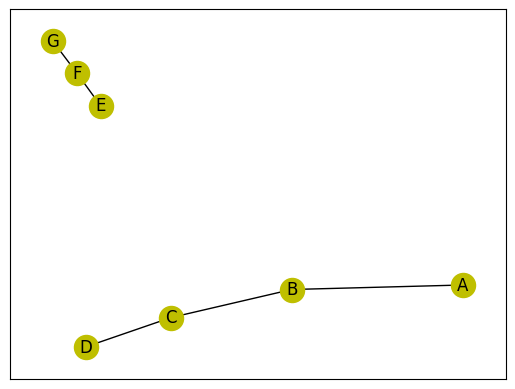

In [10]:
color =['y','g']
nx.draw_networkx(G, with_labels=True,node_color=color[0])

1
1
6405
2
6
4
3
1
6
2
2
4
1
3
1
3
41
10
1
1
1
1
2
1


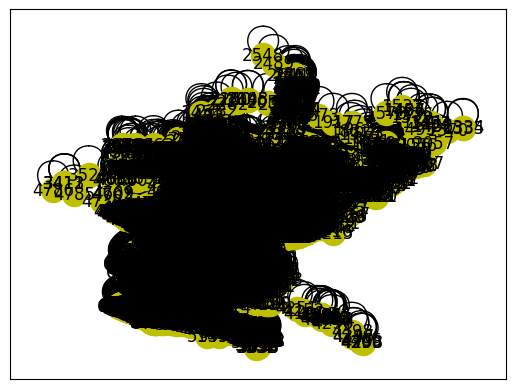

In [75]:

for item in nx.connected_components(connected_graph):
    # print(len(item))
    if len(item) > 100:
        print(len(item))
        nx.draw_networkx(connected_graph.subgraph(item), with_labels=True,node_color=color[0])

Graph with 6405 nodes and 94602 edges


In [57]:
item_graphs = nx.connected_components(connected_graph)

AttributeError: 'list' object has no attribute 'is_directed'